In [1]:
%load_ext autoreload
%autoreload 2

import math
import copy
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import uproot
import pandas as pd
import dask

import vector
import particle
import hepunits

import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers

from torch.utils.data import DataLoader

from memflow.dataset.data import RootData,ParquetData
from memflow.dataset.dataset import CombinedDataset
from memflow.dataset.tth import ttHRecoDataset,ttHGenDataset
from memflow.read_data import utils

vector.register_awkward()

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')  
if accelerator =='gpu':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

Running on GPU : True
Accelerator : gpu
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|-----------------------

In [2]:
data = ParquetData(
    files = [
        'all_jets_fullRun2_ttHTobb_forTraining_2016_PreVFP_v3.parquet',
    ],
    lazy = True,
    # N = 1000,
)
print (data)

Data object
Loaded branches:
   ... file: 462769
   ... sample: 462769
   ... tree: 462769
Branch in files not loaded:
   ... generator_info
   ... higgs
   ... jets
   ... lepton_partons
   ... lepton_reco
   ... met
   ... partons
   ... partons_matched
   ... weight


In [3]:
gen_dataset = ttHGenDataset(
    data = data,
    selection = [
        # 'boost',
        # 'partons',
        'higgs',
        'top_leptonic',
        'top_hadronic',
        'ISR',
    ],
    build = True,
    dtype = torch.float32,
)
print (gen_dataset)

Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/dataset/tth_gen
No final state recorded with `final_states_object_name` property, will not compute PS points
Parton dataset with 462769 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6, 21]
 Final states masses   : [125.25, 172.5, 172.5, 0.0]
Containing the following tensors
boost            : data ([462769, 1, 4]), mask ([462769, 1])
                   Mask exist    : [100.00%]
                   Mask corr     : [True]
                   Features      : ['x', 'y', 'z', 't']
                   Preprocessing : [False, False, False, False]
                   Selected for batches : False
partons          : data ([462769, 7, 6]), mask ([462769, 7])
                   Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 99.99%]
                   Mask corr     : [True, True, True, True, True, True, True]
                   Features      : ['pt', 'eta', 'phi', 'mass', 'pdgId', 'pr

Before preprocessing
higgs 1


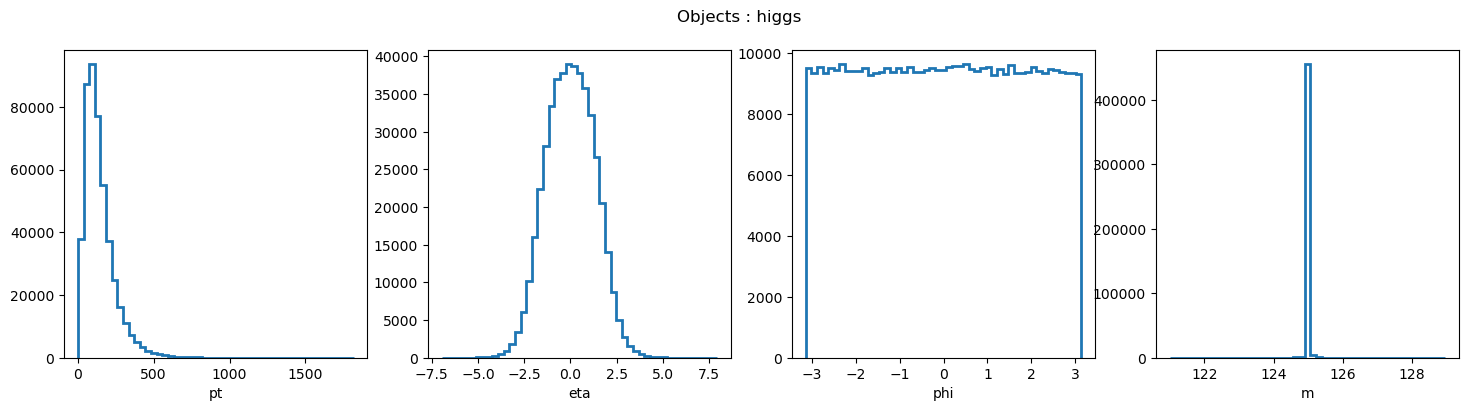

top_leptonic 1


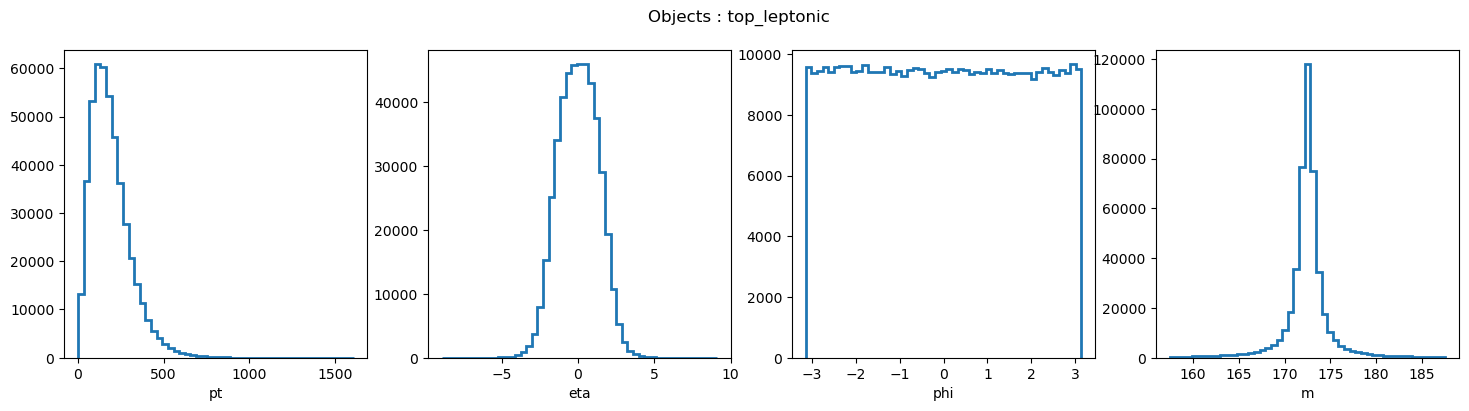

top_hadronic 1


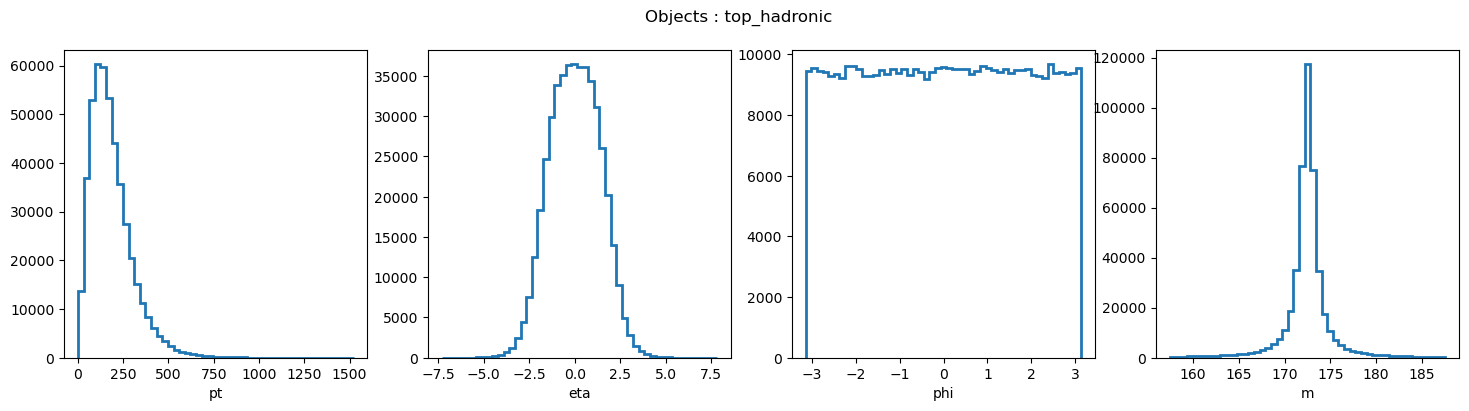

ISR 1


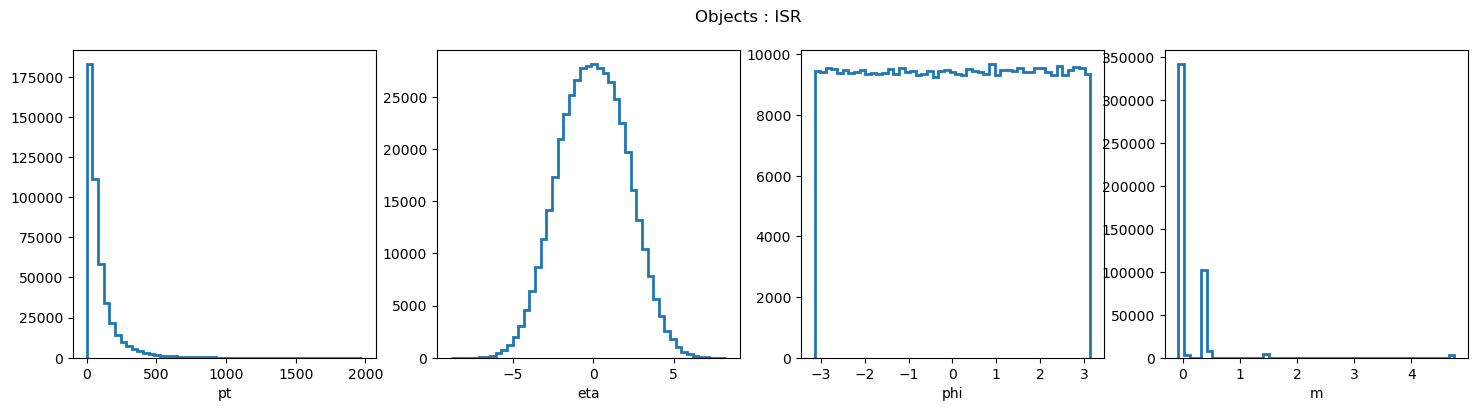

After preprocessing
higgs 1


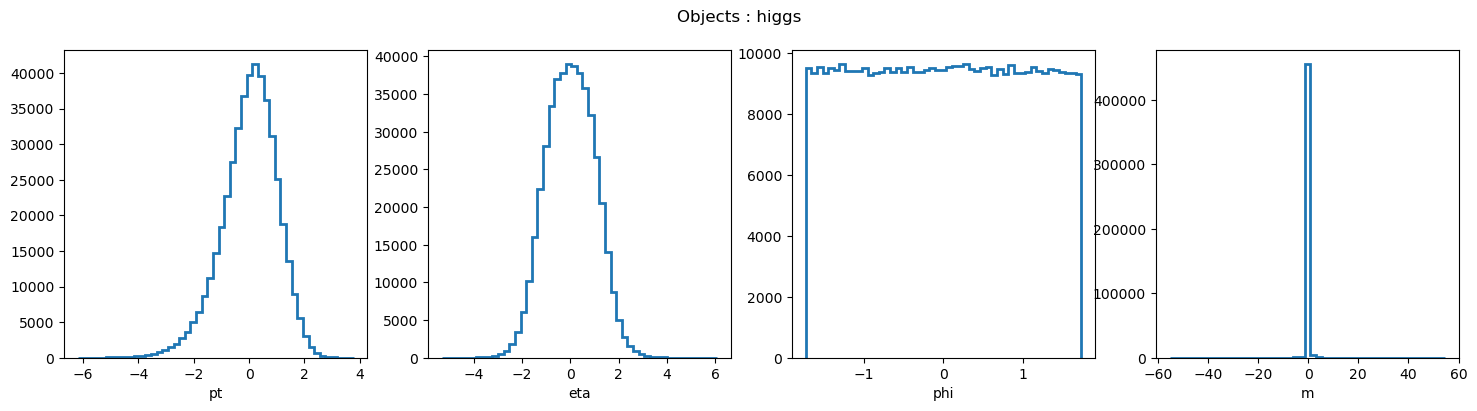

top_leptonic 1


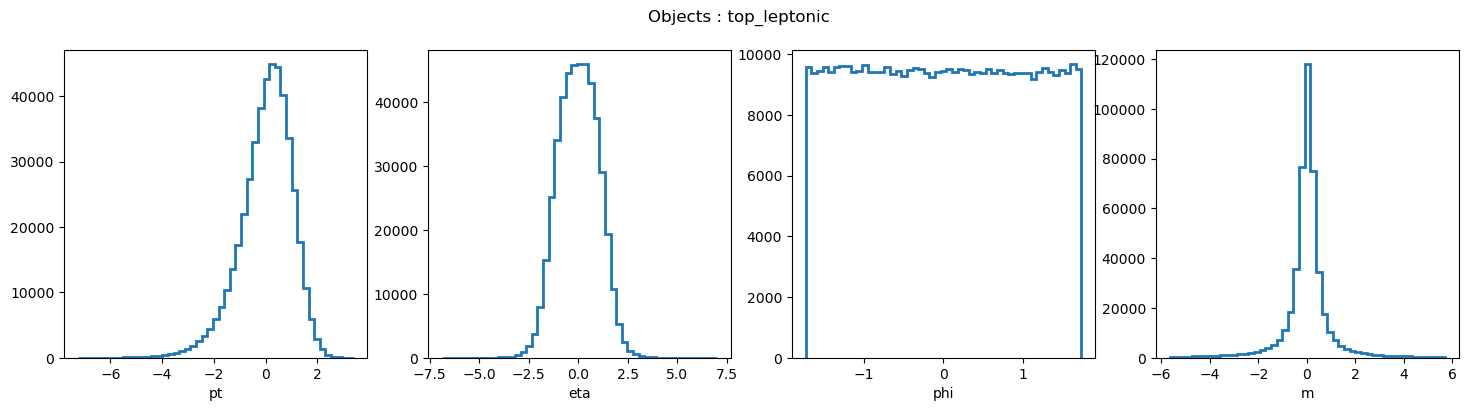

top_hadronic 1


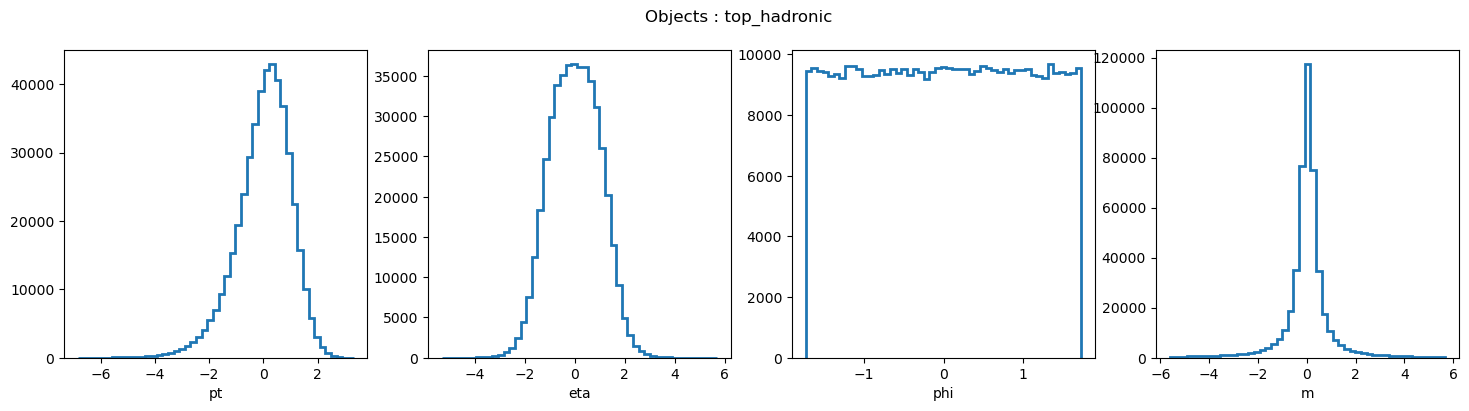

ISR 1


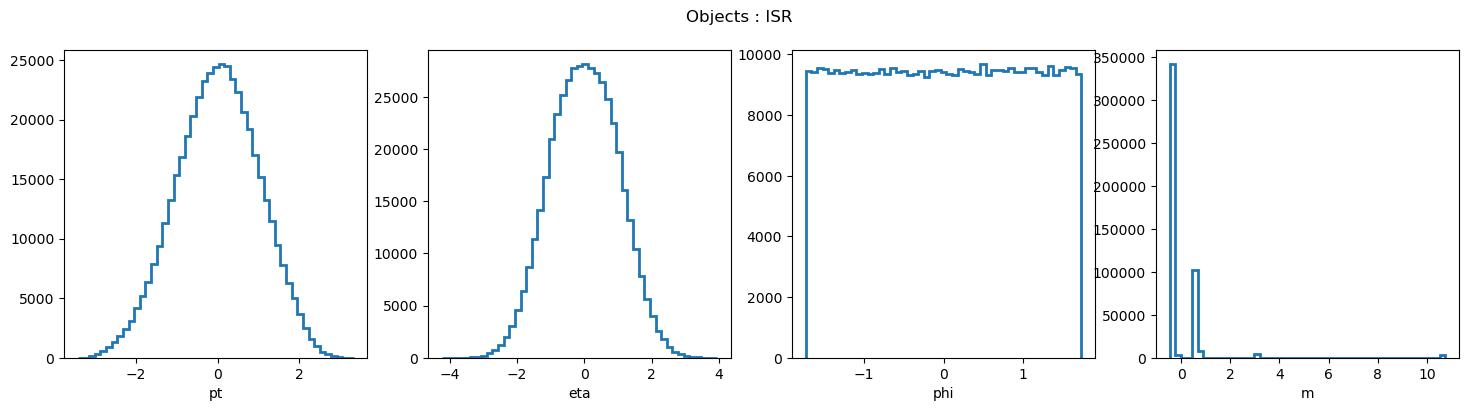

In [4]:
print ('Before preprocessing')
gen_dataset.plot(selection=True,raw=True)
print ('After preprocessing')
gen_dataset.plot(selection=True,raw=False)

In [5]:
loader_gen = DataLoader(
    gen_dataset,
    batch_size = 32,
)
batch = next(iter(loader_gen))

for obj,mask,sel in zip(batch['data'],batch['mask'],loader_gen.dataset.selection):
    print (sel,obj.shape,mask.shape)

higgs torch.Size([32, 1, 4]) torch.Size([32, 1])
top_leptonic torch.Size([32, 1, 4]) torch.Size([32, 1])
top_hadronic torch.Size([32, 1, 4]) torch.Size([32, 1])
ISR torch.Size([32, 1, 4]) torch.Size([32, 1])


In [6]:
reco_dataset = ttHRecoDataset(
    data = data,
    selection = [
        'lepton',
        'met',
        'jets',
    ],
    default_features = {
        'pt' : 0.,
        'eta' : 0.,
        'phi' : 0.,
        'm' : 0.,
        'btag' : -1.,
        'matched' : None,
        'prov' : None,
    },
    build = True,
    dtype = torch.float32,
)
print (reco_dataset)

Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/dataset/tth_reco
Reco dataset with 462769 events
Containing the following tensors
boost   : data ([462769, 1, 5]), mask ([462769, 1])
          Mask exist    : [100.00%]
          Mask corr     : [True]
          Features      : ['pt', 'eta', 'phi', 'm', 'btag']
          Preprocessing : [True, True, True, True, False]
          Selected for batches : False
jets    : data ([462769, 15, 5]), mask ([462769, 15])
          Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%, 79.92%, 46.55%, 20.02%, 6.95%, 2.11%, 0.57%, 0.13%, 0.03%, <0.01%, <0.01%, <0.01%]
          Mask corr     : [True, True, True, True, False, False, False, False, False, False, False, False, False, False, False]
          Features      : ['pt', 'eta', 'phi', 'm', 'btag']
          Preprocessing : [True, True, True, True, False]
          Selected for batches : True
lepton  : data ([462769, 1, 5]), mask ([462769, 1])
          Mask exist    : [100.00%]
 

Before preprocessing
lepton 1


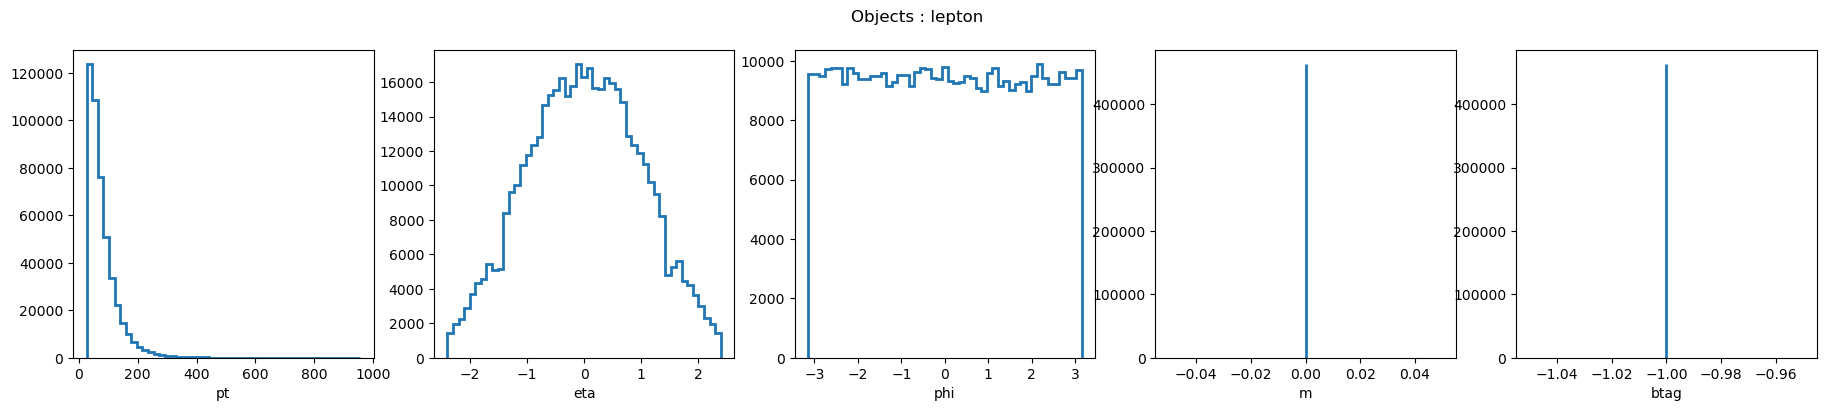

met 1


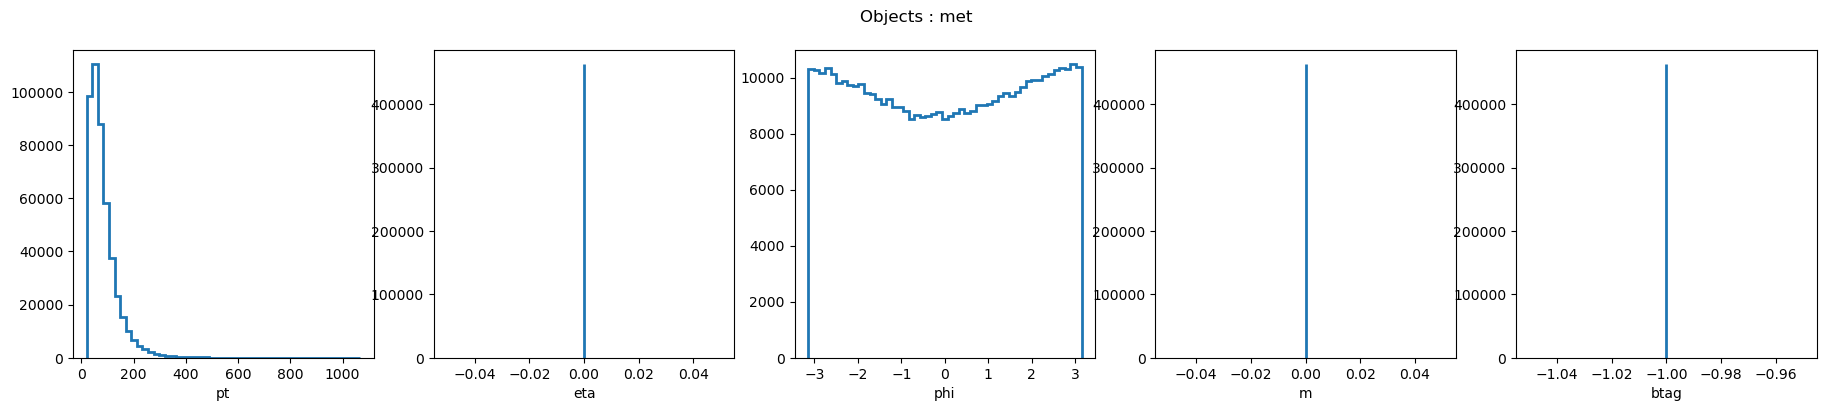

jets 15


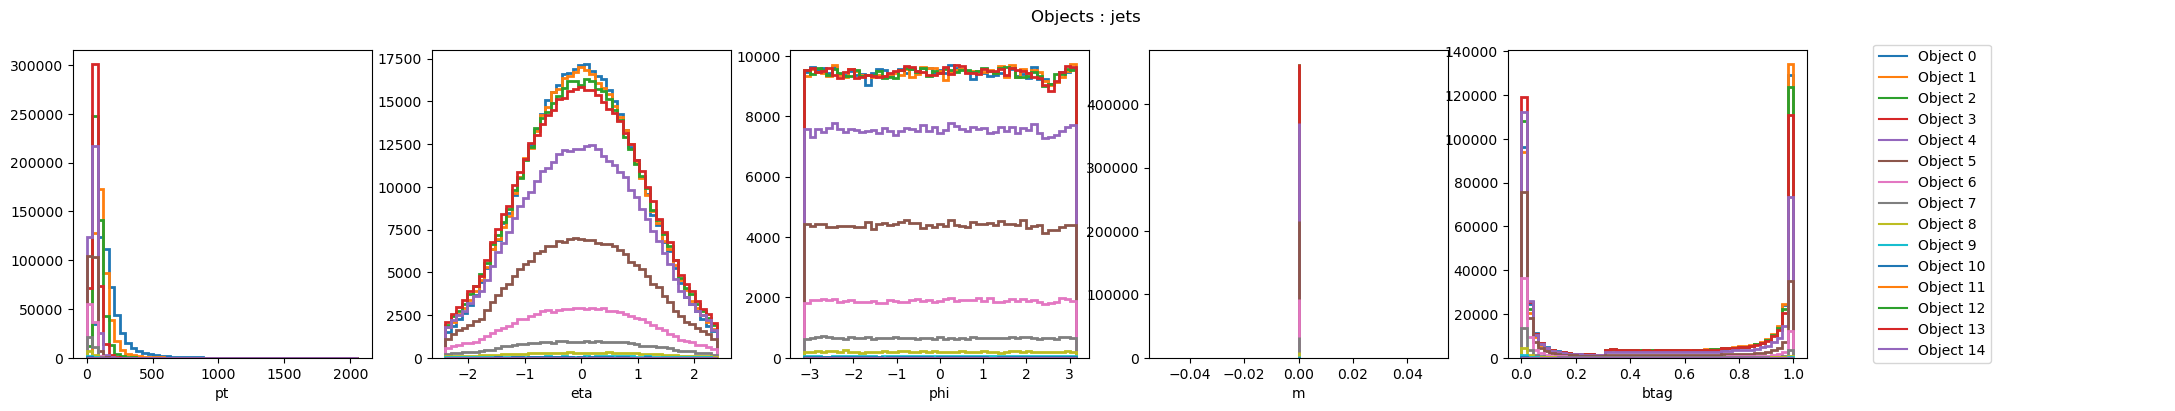

After preprocessing
lepton 1


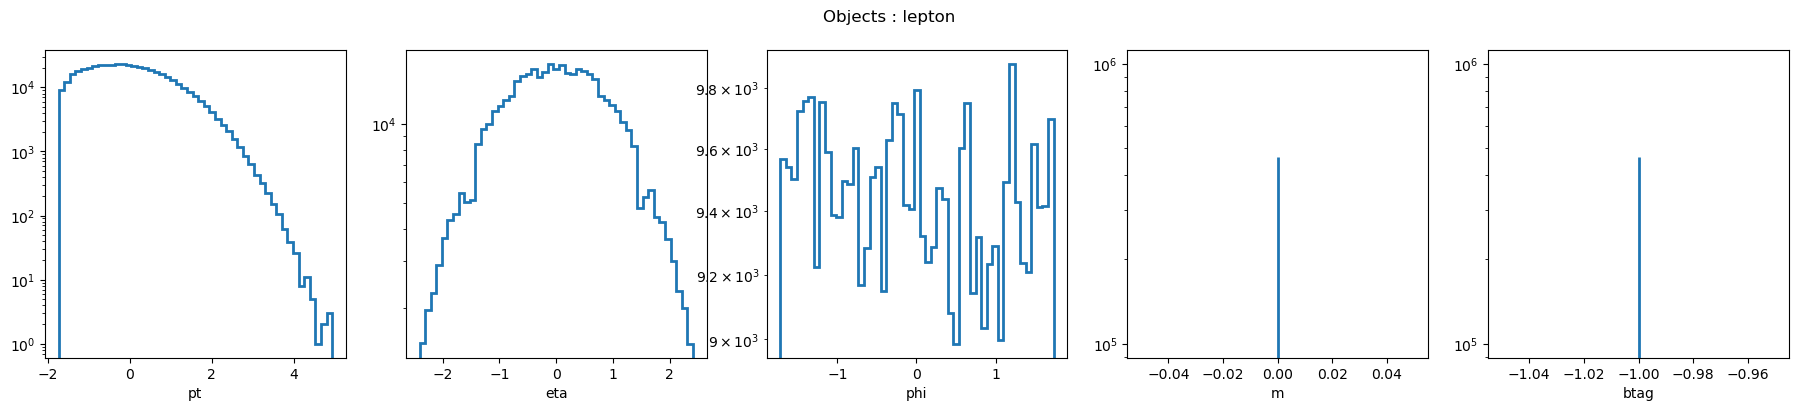

met 1


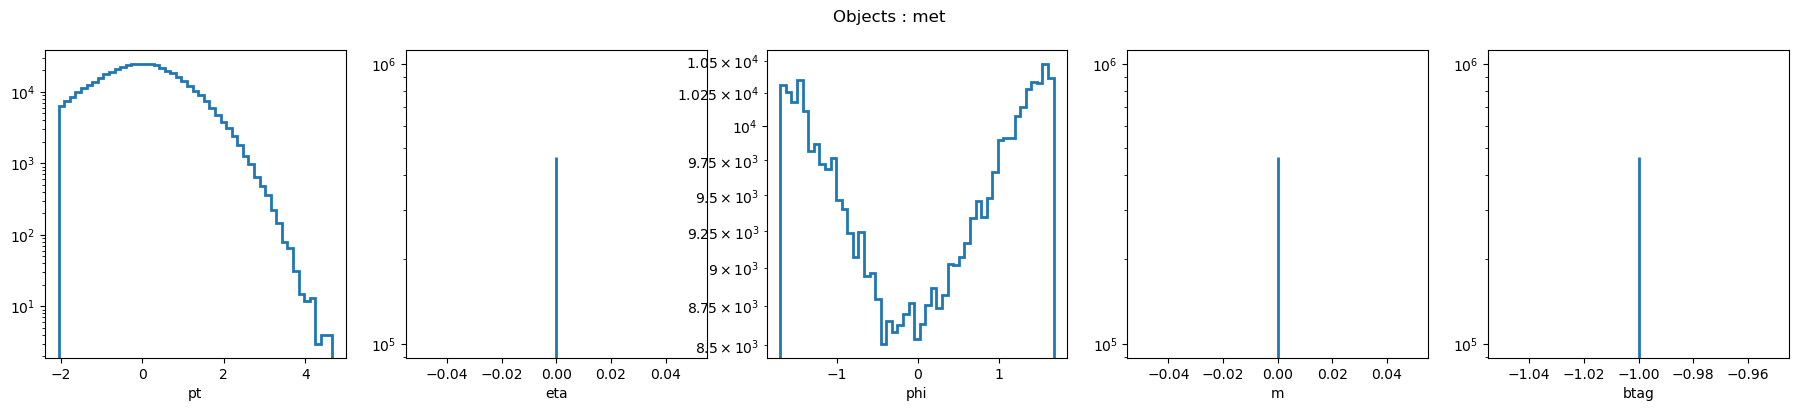

jets 15


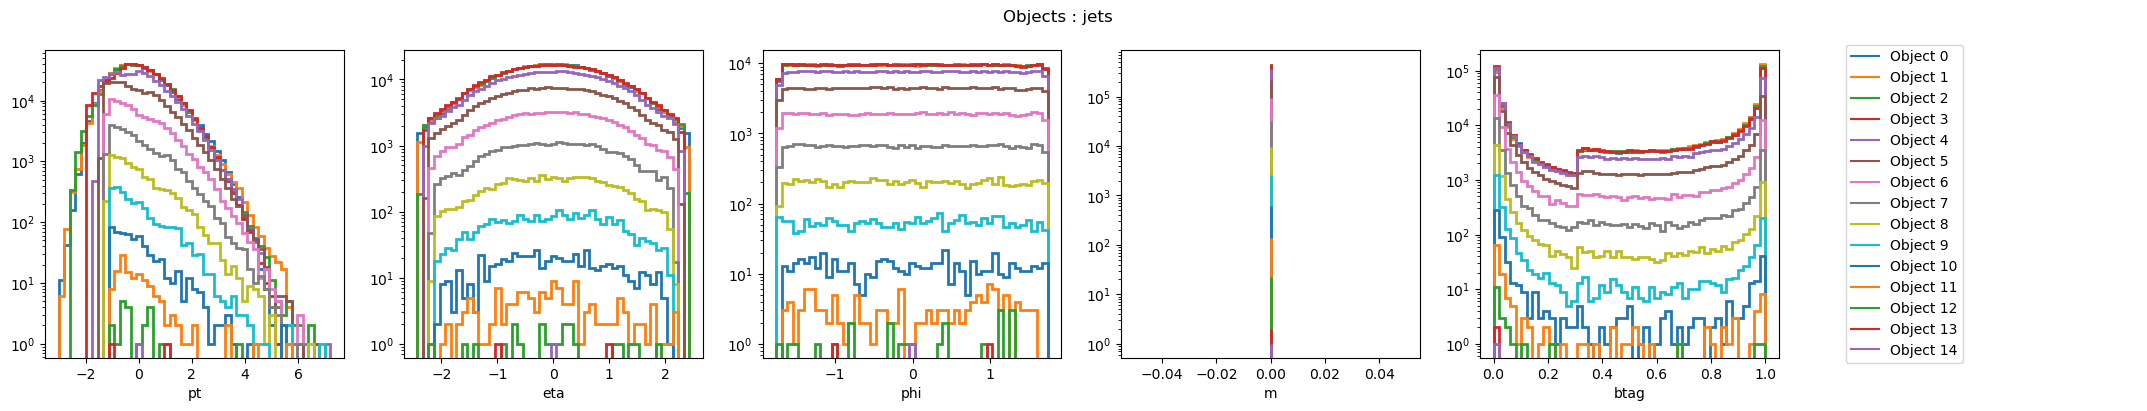

In [7]:
print ('Before preprocessing')
reco_dataset.plot(selection=True,raw=True)
print ('After preprocessing')
reco_dataset.plot(selection=True,raw=False,log=True)

In [8]:
loader_reco = DataLoader(
    reco_dataset,
    batch_size = 32,
)
batch = next(iter(loader_reco))

for obj,mask,sel in zip(batch['data'],batch['mask'],loader_reco.dataset.selection):
    print (sel,obj.shape,mask.shape)

lepton torch.Size([32, 1, 5]) torch.Size([32, 1])
met torch.Size([32, 1, 5]) torch.Size([32, 1])
jets torch.Size([32, 15, 5]) torch.Size([32, 15])


In [9]:
comb_dataset = CombinedDataset(
    gen_dataset = gen_dataset,
    reco_dataset = reco_dataset,
)
print (comb_dataset)

Combined dataset (extracting 462769 events of the following) :
Parton dataset with 462769 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6, 21]
 Final states masses   : [125.25, 172.5, 172.5, 0.0]
Containing the following tensors
boost            : data ([462769, 1, 4]), mask ([462769, 1])
                   Mask exist    : [100.00%]
                   Mask corr     : [True]
                   Features      : ['x', 'y', 'z', 't']
                   Preprocessing : [False, False, False, False]
                   Selected for batches : False
partons          : data ([462769, 7, 6]), mask ([462769, 7])
                   Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 99.99%]
                   Mask corr     : [True, True, True, True, True, True, True]
                   Features      : ['pt', 'eta', 'phi', 'mass', 'pdgId', 'prov']
                   Preprocessing : [True, True, True, True, False, False]
                   Selected for ba

In [10]:
loader_comb = DataLoader(
    comb_dataset,
    batch_size = 256,
)
batch = next(iter(loader_comb))

print ('Reco')
for obj,mask,sel in zip(batch['reco']['data'],batch['reco']['mask'],loader_reco.dataset.selection):
    print (sel,obj.shape,mask.shape)
print ('Gen')
for obj,mask,sel in zip(batch['gen']['data'],batch['gen']['mask'],loader_gen.dataset.selection):
    print (sel,obj.shape,mask.shape)

Reco
lepton torch.Size([256, 1, 5]) torch.Size([256, 1])
met torch.Size([256, 1, 5]) torch.Size([256, 1])
jets torch.Size([256, 15, 5]) torch.Size([256, 15])
Gen
higgs torch.Size([256, 1, 4]) torch.Size([256, 1])
top_leptonic torch.Size([256, 1, 4]) torch.Size([256, 1])
top_hadronic torch.Size([256, 1, 4]) torch.Size([256, 1])
ISR torch.Size([256, 1, 4]) torch.Size([256, 1])


In [11]:
from memflow.transfer_flow.transfer_flow_model import TransferFlow

model = TransferFlow(
    embed_dim = 64,
    embed_act = nn.GELU,
    n_reco_particles_per_type = reco_dataset.number_particles_per_type,
    n_gen_particles_per_type = gen_dataset.number_particles_per_type,
    reco_input_features = reco_dataset.input_features,
    gen_input_features = gen_dataset.input_features,
    flow_input_features = [
        ['pt','eta','phi','m'], # leptons
        ['pt','phi'],       # met
        ['pt','eta','phi'], # jets
    ],
    reco_mask_corr = reco_dataset.correlation_mask,
    gen_mask_corr = gen_dataset.correlation_mask,
    transformer_args = {
        'nhead' : 8,
        'num_encoder_layers' : 6, 
        'num_decoder_layers' : 6, 
        'dim_feedforward' : 256, 
        'dropout' : 0., 
        'activation' : 'gelu', 
    },
    flow_args = {
        'bins' : 16,
        'transforms' : 1,
        'randperm' : False,
        'passes' : None,
        # 'univariate'
        # 'univariate_kwargs' : {"bound": 1},
        'hidden_features' : [128] * 3,   
    },
    onehot_encoding = True,
)

batch = next(iter(loader_comb))
print (model(batch))

print (model)

tensor(32.3568, grad_fn=<NegBackward0>)
TransferFlow(
  (gen_embeddings): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): GELU(approximate='none')
    )
  )
  (reco_embeddings): ModuleList(
    (0-2): 3 x Sequential(
      (0): Linear(in_features=23, out_features=64, bias=True)
      (1): GELU(approximate='none')
    )
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=256, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=256, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elem

In [12]:
##### Parameters #####
epochs = 100
steps_per_epoch_train = math.ceil(len(comb_dataset)/loader_comb.batch_size)
# steps_per_epoch_valid = math.ceil(len(dataset_valid)/loader_valid.batch_size)

print (f'Training   : Batch size = {loader_comb.batch_size} => {steps_per_epoch_train} steps per epoch')
# print (f'Validation : Batch size = {loader_valid.batch_size} => {steps_per_epoch_valid} steps per epoch')
##### Optimizer #####
optimizer = optim.RAdam(model.parameters(), lr=1e-3, weight_decay=1e-5)
model.set_optimizer(optimizer)

##### Scheduler #####
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer = optimizer, 
    max_lr = 1e-3, 
    epochs = epochs, 
    steps_per_epoch = steps_per_epoch_train, 
    pct_start = 0.1, 
    anneal_strategy='cos', 
    cycle_momentum=True, 
    base_momentum=0.85, 
    max_momentum=0.95, 
    div_factor=100.0, 
    final_div_factor=10000.0,
)
model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss',
        'strict' : True,
        'name' : 'scheduler',
    }
)

##### Callbacks #####
# from callbacks import MomentumPredictorCallback, HistoryCallback
callbacks = [
    L.pytorch.callbacks.LearningRateMonitor(logging_interval = 'epoch'),
    L.pytorch.callbacks.ModelSummary(max_depth=2),
] 

##### Logger #####
logger = pl_loggers.CometLogger(
    save_dir = '../comet_logs',
    project_name = 'mem-flow',
    experiment_name = 'model',
    offline = True,
) 
logger.log_graph(model)
# logger.log_hyperparams()
# logger.experiment.log_code(folder='../src/')
logger.experiment.log_notebook(filename=globals()['__session__'],overwrite=True)

##### Trainer #####
trainer = L.Trainer(    
    min_epochs = 5,
    max_epochs = epochs,
    callbacks = callbacks,
    devices = 'auto',
    accelerator = accelerator,
    logger = logger,
    log_every_n_steps = steps_per_epoch_train,
)
##### Fit #####
trainer.fit(
    model = model, 
    train_dataloaders = loader_comb,
    # val_dataloaders = loader_comb,
)



Training   : Batch size = 256 => 1808 steps per epoch


CometLogger will be initialized in offline mode
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: COMET_API_KEY was set, but is ignored in OfflineExperiment(); remember to set when you upload
/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/ ...
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU availabl

Training: |                                               | 0/? [00:00<?, ?it/s]

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml OfflineExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : model
COMET INFO:     url                   : [OfflineExperiment will get URL after upload]
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     scheduler [28]  : (1.0000000000000026e-05, 0.0009999999999068126)
COMET INFO:     train/loss [27] : (4.940579891204834, 19.61858367919922)
COMET INFO:   Others:
COMET INFO:     Created from       : pytorch-lightning
COMET INFO:     Name               : model
COMET INFO:     offline_experiment : True
COMET INFO:   Uploads

particle 0 of type lepton
particle 0 of type met
particle 0 of type jets
particle 1 of type jets
particle 2 of type jets
particle 3 of type jets
particle 4 of type jets
particle 5 of type jets
particle 6 of type jets
particle 7 of type jets
particle 8 of type jets
particle 9 of type jets
particle 10 of type jets
particle 11 of type jets
particle 12 of type jets
particle 13 of type jets
particle 14 of type jets
Event #0


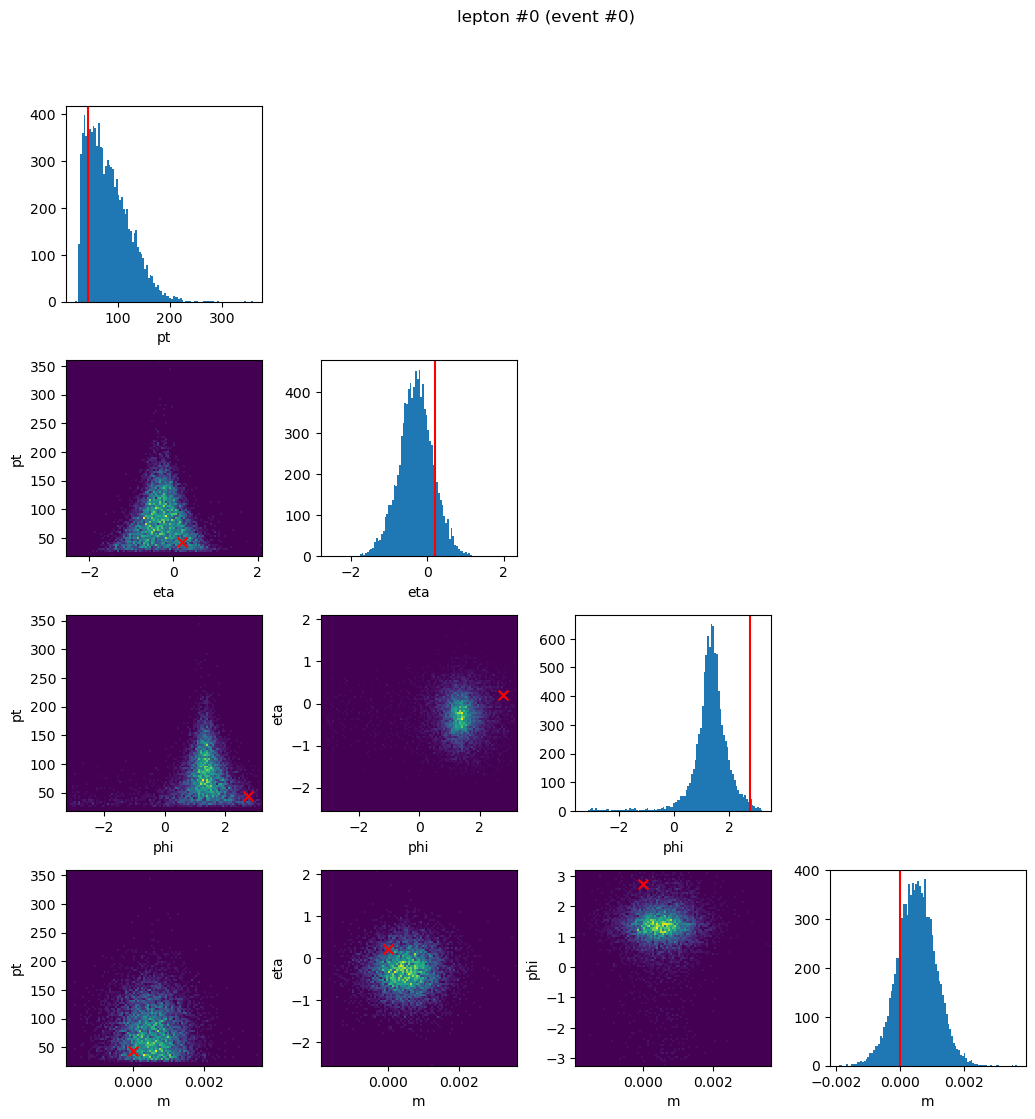

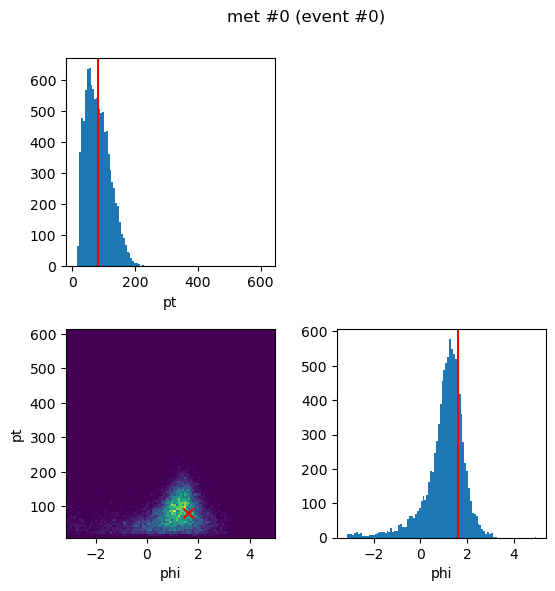

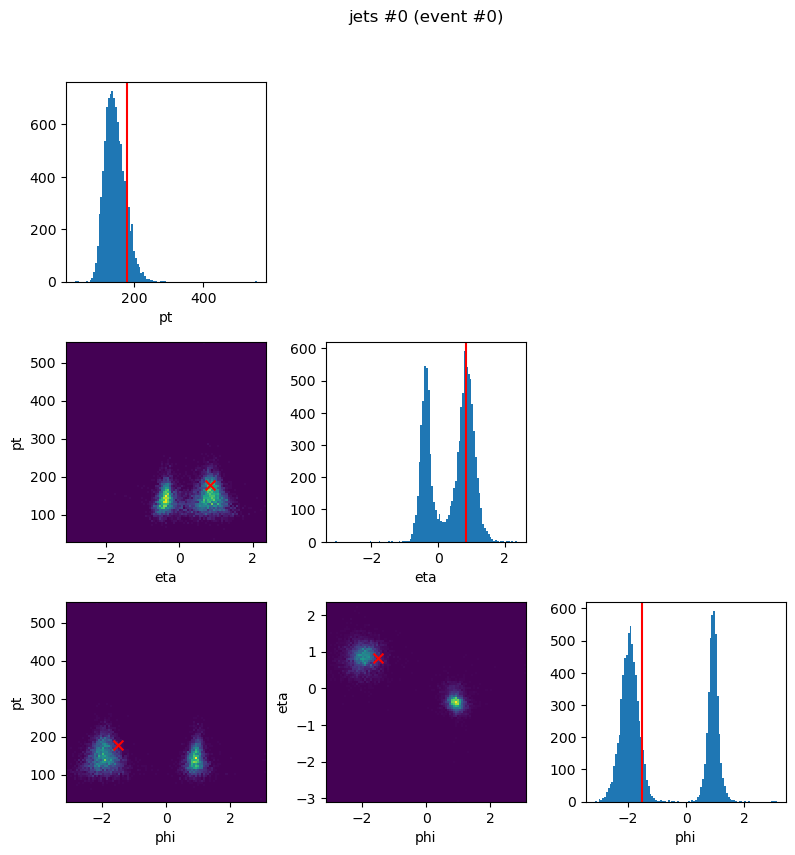

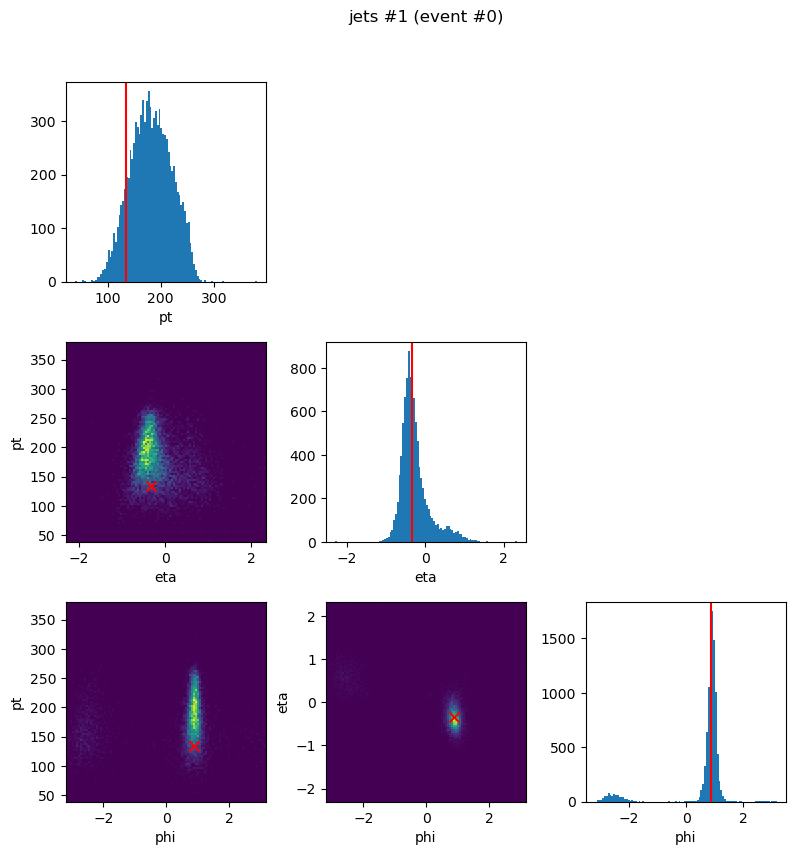

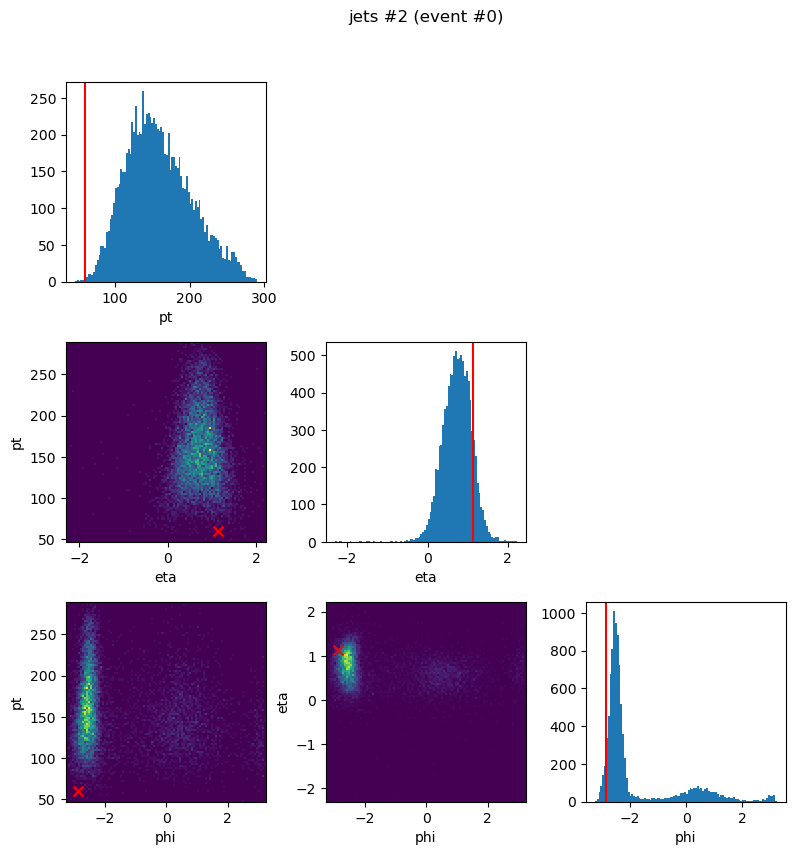

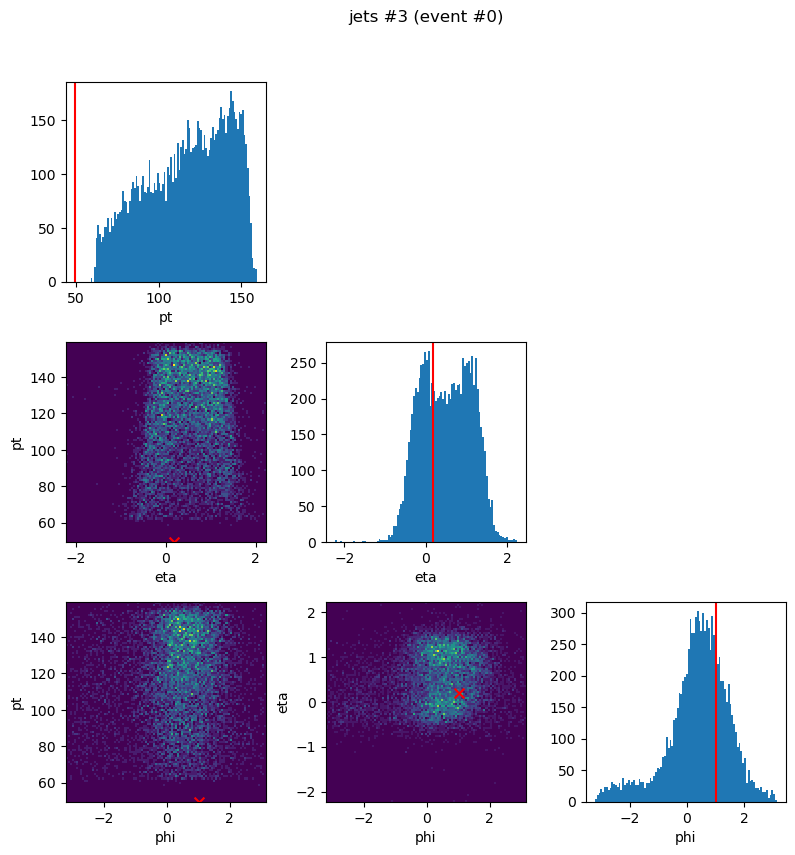

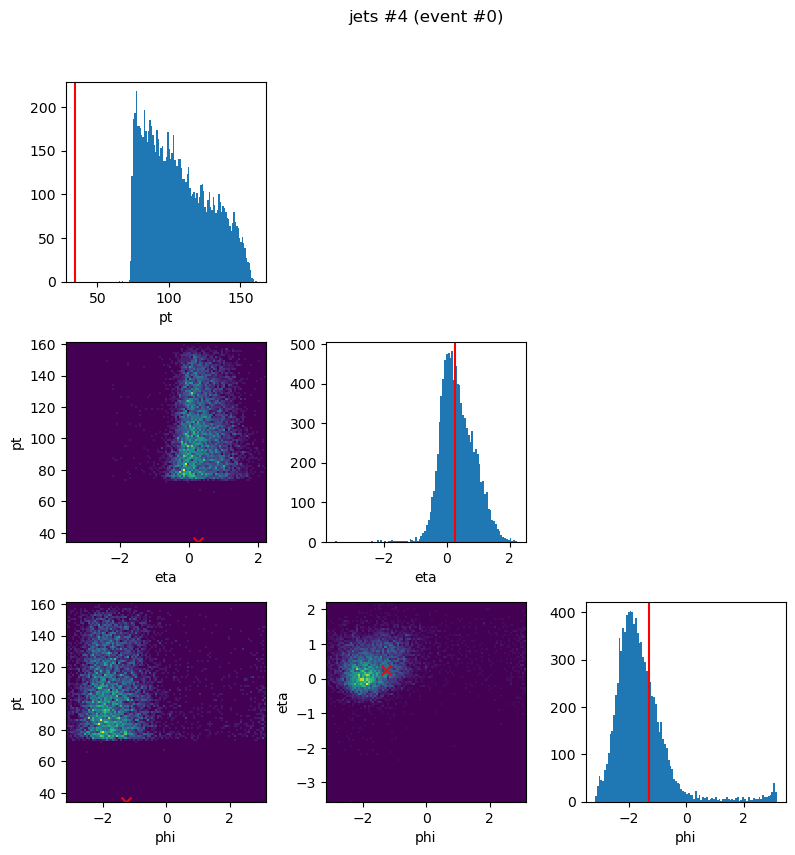

In [15]:

def plot_particle(sample,reco,features,title):
    # sample (N,F)
    # reco (F)
    assert sample.shape[1] ==  reco.shape[0]
    assert reco.shape[0] == len(features)
    N = len(features)
    fig,axs = plt.subplots(N,N,figsize=(3*N,3*N))
    fig.suptitle(title)
    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,hspace=0.3,wspace=0.3)
    for i in range(N):
        for j in range(N):
            if j > i:
                axs[i,j].axis('off')
            elif j == i:
                axs[i,j].hist(sample[:,i],bins=100)
                axs[i,j].axvline(reco[i],color='r')
                axs[i,j].set_xlabel(features[i])
            else:
                bins_x = np.linspace(
                    min(sample[:,i].min(),reco[i]),
                    max(sample[:,i].max(),reco[i]),
                    100,
                )
                bins_y = np.linspace(
                    min(sample[:,j].min(),reco[j]),
                    max(sample[:,j].max(),reco[j]),
                    100,
                )
                axs[i,j].hist2d(sample[:,i],sample[:,j],bins=(bins_x,bins_y))
                axs[i,j].scatter(reco[i],reco[j],marker='x',color='r',s=50)
                axs[i,j].set_xlabel(features[i])
                axs[i,j].set_ylabel(features[j])
    plt.show()

def plot_all_particles(model,gen_data,gen_mask_exist,reco_data,reco_mask_exist,N_sample):
    samples = model.sample(gen_data,gen_mask_exist,reco_data,reco_mask_exist,N_sample)
    N_event = gen_data[0].shape[0]

    # Inverse preprocessing #
    idx = 0
    for i in range(len(reco_data)):
        name = reco_dataset.selection[i]
        preprocessing = reco_dataset._preprocessing[name]
        fields = reco_dataset._fields[name]
        if preprocessing is not None:
            reco_data[i] = preprocessing.inverse(reco_data[i],reco_mask_exist[i],fields)
        for j in range(reco_dataset.number_particles_per_type[i]):
            print (f'particle {j} of type {name}')
            if preprocessing is not None:
                flow_fields = [fields[k] for k in model.flow_indices[i]]
                # preprocessing expects : 
                #   data = [events, particles, features]
                #   mask = [events, particles]
                # samples dims = [samples, events, particles, features]
                # -> need a loop over samples
                samples[idx] = torch.cat(
                    [
                        preprocessing.inverse(samples[idx][k],reco_mask_exist[i],flow_fields).unsqueeze(0)
                            for k in range(N_sample)
                    ],
                    dim = 0,
                )
            idx += 1


    # Event loop #
    for event in range(N_event):
        print (f'Event #{event}')
        idx = 0
        for i,(n,features,indices) in enumerate(zip(model.n_reco_particles_per_type,model.flow_input_features,model.flow_indices)):
            for j in range(n):
                if reco_mask_exist[i][event,j]:
                    plot_particle(samples[idx][:,event,0,:],reco_data[i][event,j,indices],features,f'{reco_dataset.selection[i]} #{j} (event #{event})')
                idx += 1



batch = comb_dataset.batch_by_index([0])
plot_all_particles(
    model.to('cpu'),
    batch['gen']['data'],
    batch['gen']['mask'],
    batch['reco']['data'],
    batch['reco']['mask'],
    N_sample = 10000,
)